In [4]:
import pandas as pd

a = pd.read_html("https://s3.amazonaws.com/tripdata/index.html")

In [47]:
import time
import io
from selenium import webdriver
import pandas as pd
from bs4 import BeautifulSoup
import requests
import zipfile
import os


driver = webdriver.Firefox()

url = 'https://s3.amazonaws.com/tripdata/index.html'

page = driver.get(url)
time.sleep(2)


In [90]:
def get_table_from_response(response):
    zip_content = io.BytesIO(response.content)

    with zipfile.ZipFile(zip_content, 'r') as zip_file:
        file_list = [file for file in zip_file.namelist() if not ("/" in file) and (file.endswith(".csv"))]
        
        if len(file_list) == 1:
            file_name = file_list[0]
            extracted_content = zip_file.read(file_name)
            csv_file = extracted_content.decode('utf-8')
            return pd.read_csv(io.StringIO(csv_file)) 
        else:
            return False    

def process_raw_data(df):
    df["starttime"] = pd.to_datetime(df["starttime"])
    one_hot_gender = pd.get_dummies(df["gender"])
    df = df.drop("gender",axis = 1)
    df = df.join(one_hot_gender).rename(columns={0:"Uknown gender", 1: "Male", 2: "Female"})
    # df = df.groupby([pd.Grouper(key='starttime', freq='H'), 'start station id',
    #    'start station name', 'start station latitude',
    #    'start station longitude', 'end station id', 'end station name',
    #    'end station latitude', 'end station longitude']).agg({"tripduration": ["mean", "sum"], "usertype": "size"})
    return df
        
soup = BeautifulSoup(driver.page_source, 'html.parser')
data_table = soup.find('table')

old_cols = ['tripduration', 'starttime', 'stoptime', 'start station id',
       'start station name', 'start station latitude',
       'start station longitude', 'end station id', 'end station name',
       'end station latitude', 'end station longitude', 'bikeid', 'usertype',
       'birth year', 'gender']

df = pd.DataFrame()

i=0
for tag in data_table.findAll("a"):
    print(tag)
    response = requests.get(tag["href"])
    if response.status_code == 200:
        df_temp = get_table_from_response(response)
        if type(df_temp) == bool:
            continue
        else:
            df_temp = process_raw_data(df_temp)
            df = pd.concat([df, df_temp], axis=0)
            print(list(df.columns)==old_cols)
            old_cols=list(df.columns)
    
    if i==3:
        break
    i+=1

<a href="https://s3.amazonaws.com/tripdata/201306-citibike-tripdata.zip">201306-citibike-tripdata.zip</a>
False
<a href="https://s3.amazonaws.com/tripdata/201307-201402-citibike-tripdata.zip">201307-201402-citibike-tripdata.zip</a>
<a href="https://s3.amazonaws.com/tripdata/201307-citibike-tripdata.zip">201307-citibike-tripdata.zip</a>
True
<a href="https://s3.amazonaws.com/tripdata/201308-citibike-tripdata.zip">201308-citibike-tripdata.zip</a>
True
<a href="https://s3.amazonaws.com/tripdata/201309-citibike-tripdata.zip">201309-citibike-tripdata.zip</a>
True


In [91]:
df

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,Uknown gender,Male,Female
0,695,2013-06-01 00:00:01,2013-06-01 00:11:36,444,Broadway & W 24 St,40.742354,-73.989151,434.0,9 Ave & W 18 St,40.743174,-74.003664,19678,Subscriber,1983.0,False,True,False
1,693,2013-06-01 00:00:08,2013-06-01 00:11:41,444,Broadway & W 24 St,40.742354,-73.989151,434.0,9 Ave & W 18 St,40.743174,-74.003664,16649,Subscriber,1984.0,False,True,False
2,2059,2013-06-01 00:00:44,2013-06-01 00:35:03,406,Hicks St & Montague St,40.695128,-73.995951,406.0,Hicks St & Montague St,40.695128,-73.995951,19599,Customer,NaN,True,False,False
3,123,2013-06-01 00:01:04,2013-06-01 00:03:07,475,E 15 St & Irving Pl,40.735243,-73.987586,262.0,Washington Park,40.691782,-73.973730,16352,Subscriber,1960.0,False,True,False
4,1521,2013-06-01 00:01:22,2013-06-01 00:26:43,2008,Little West St & 1 Pl,40.705693,-74.016777,310.0,State St & Smith St,40.689269,-73.989129,15567,Subscriber,1983.0,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1034354,93,2013-09-30 23:59:16,2013-10-01 00:00:49,360,William St & Pine St,40.707179,-74.008873,195.0,Liberty St & Broadway,40.709056,-74.010434,20594,Subscriber,1989,False,True,False
1034355,363,2013-09-30 23:59:21,2013-10-01 00:05:24,2003,1 Ave & E 18 St,40.734161,-73.980243,459.0,W 20 St & 11 Ave,40.746745,-74.007756,15213,Customer,\N,True,False,False
1034356,562,2013-09-30 23:59:30,2013-10-01 00:08:52,293,Lafayette St & E 8 St,40.730287,-73.990765,463.0,9 Ave & W 16 St,40.742065,-74.004432,17938,Subscriber,1967,False,True,False
1034357,1237,2013-09-30 23:59:40,2013-10-01 00:20:17,478,11 Ave & W 41 St,40.760301,-73.998842,318.0,E 43 St & Vanderbilt Ave,40.753202,-73.977987,15931,Customer,\N,True,False,False


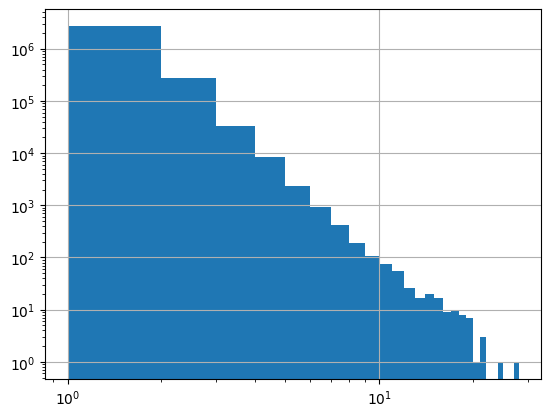

In [80]:
ax = df[0].hist(bins=27)
ax.set_yscale("log")
ax.set_xscale("log")

In [81]:
df

,starttime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,0
0,2013-06-01 00:00:00,72,W 52 St & 11 Ave,40.767272,-73.993929,478.0,11 Ave & W 41 St,40.760301,-73.998842,1
1,2013-06-01 00:00:00,79,Franklin St & W Broadway,40.719116,-74.006667,294.0,Washington Square E,40.730494,-73.995721,1
2,2013-06-01 00:00:00,79,Franklin St & W Broadway,40.719116,-74.006667,305.0,E 58 St & 3 Ave,40.760958,-73.967245,1
3,2013-06-01 00:00:00,79,Franklin St & W Broadway,40.719116,-74.006667,439.0,E 4 St & 2 Ave,40.726281,-73.989780,1
4,2013-06-01 00:00:00,83,Atlantic Ave & Fort Greene Pl,40.683826,-73.976323,420.0,Clermont Ave & Lafayette Ave,40.687645,-73.969689,1
...,...,...,...,...,...,...,...,...,...,...
917676,2013-09-30 23:00:00,2021,W 45 St & 8 Ave,40.759291,-73.988597,281.0,Grand Army Plaza & Central Park S,40.764397,-73.973715,2
917677,2013-09-30 23:00:00,2022,E 59 St & Sutton Pl,40.758491,-73.959206,428.0,E 3 St & 1 Ave,40.724677,-73.987834,1
917678,2013-09-30 23:00:00,2022,E 59 St & Sutton Pl,40.758491,-73.959206,483.0,E 12 St & 3 Ave,40.732233,-73.988900,1
917679,2013-09-30 23:00:00,2022,E 59 St & Sutton Pl,40.758491,-73.959206,517.0,Pershing Square S,40.751493,-73.977988,1
